In [1]:
from collections import OrderedDict
import re
import os

import sys
sys.path.append('./src') 

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "./models"

In [4]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
3,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
1,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
0,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
2,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained


In [54]:
# task = "linear_regression"
# task = "sparse_linear_regression"
task = "decision_tree"
# task = "relu_2nn_regression"

run_id = "pretrained"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

linear_regression_pretrained pretrained


100%|██████████| 15/15 [00:00<00:00, 105561.34it/s]


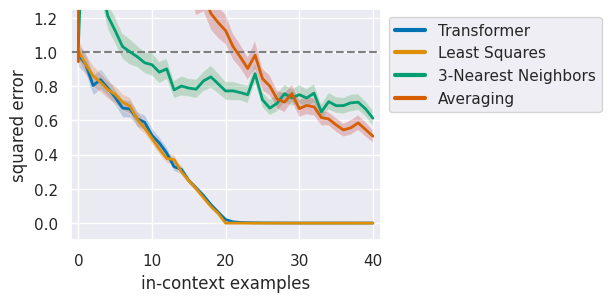

In [10]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()

In [12]:
metrics.keys()

dict_keys(['half_subspace', 'noisyLR', 'orthogonal_train_test', 'overlapping_train_test', 'random_quadrants', 'scale-x=0.333', 'scale-x=0.5', 'scale-x=2', 'scale-x=3', 'scale-y=0.333', 'scale-y=0.5', 'scale-y=2', 'scale-y=3', 'skewed', 'standard'])

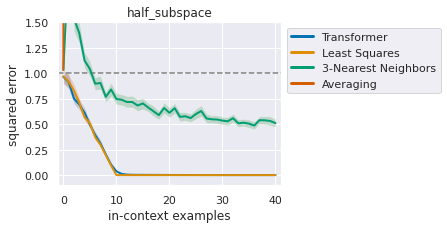

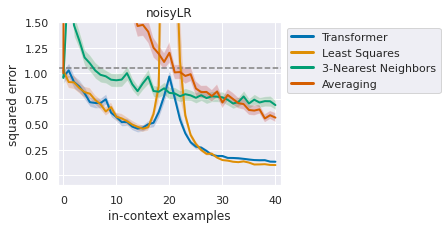

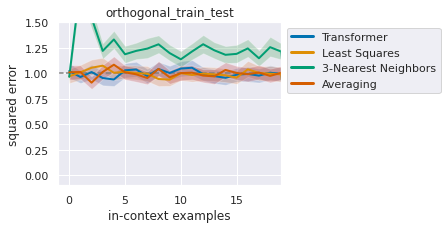

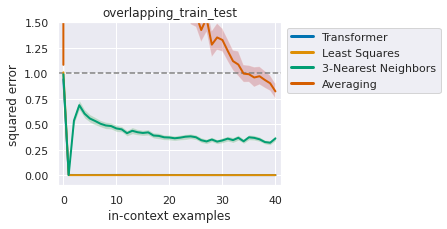

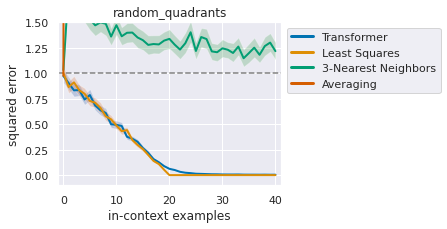

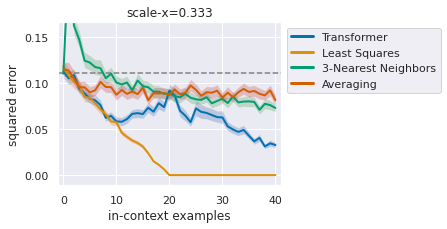

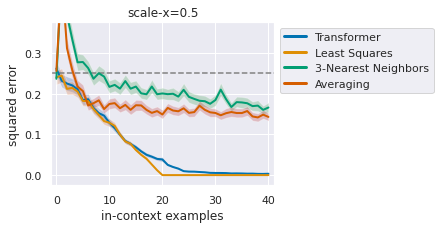

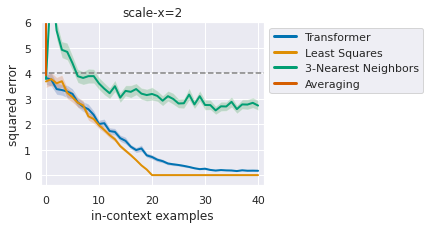

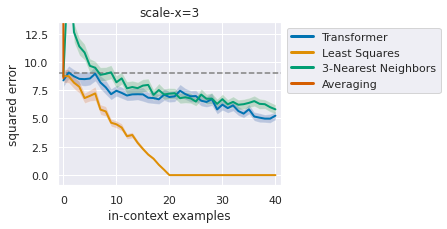

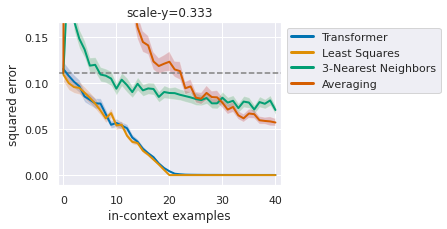

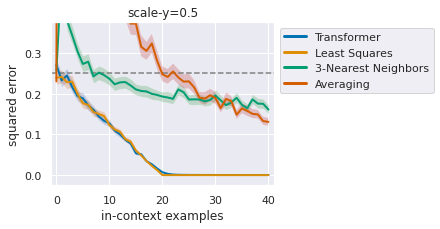

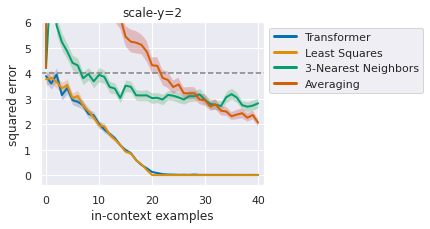

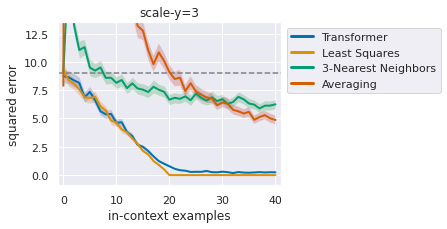

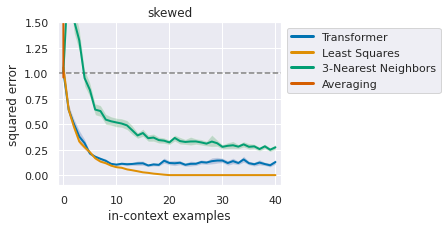

In [5]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [22]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [23]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [24]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [25]:
task, xs.shape, ys.shape, n_dims, batch_size, conf.training.curriculum.points.end, conf.training.task_kwargs, model

(<tasks.DecisionTree at 0x7fe3f5702340>,
 torch.Size([64, 101, 20]),
 torch.Size([64, 101]),
 20,
 64,
 101,
 Munch({'depth': 4}),
 TransformerModel(
   (_read_in): Linear(in_features=20, out_features=256, bias=True)
   (_backbone): GPT2Model(
     (wte): Embedding(50257, 256)
     (wpe): Embedding(402, 256)
     (drop): Dropout(p=0.0, inplace=False)
     (h): ModuleList(
       (0): GPT2Block(
         (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (attn): GPT2Attention(
           (c_attn): Conv1D()
           (c_proj): Conv1D()
           (attn_dropout): Dropout(p=0.0, inplace=False)
           (resid_dropout): Dropout(p=0.0, inplace=False)
         )
         (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
         (mlp): GPT2MLP(
           (c_fc): Conv1D()
           (c_proj): Conv1D()
           (act): NewGELUActivation()
           (dropout): Dropout(p=0.0, inplace=False)
         )
       )
       (1): GPT2Block(
         (ln_1): LayerNorm

In [12]:
with torch.no_grad():
    pred = model(xs, ys)

In [14]:
conf.training.task

'decision_tree'

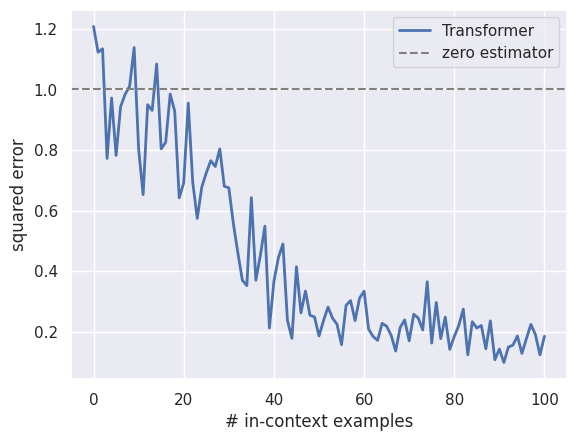

In [13]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [15]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

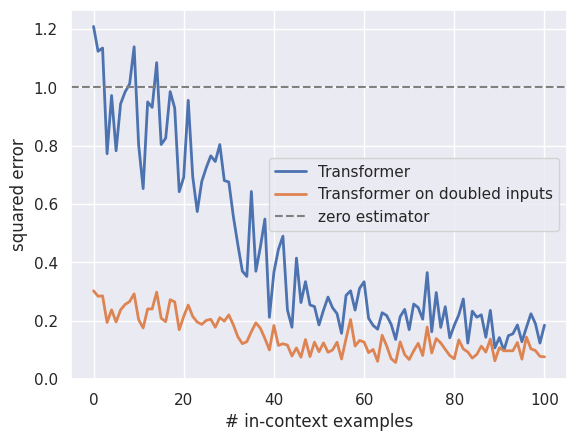

In [16]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.

### Linear Regression

In [51]:
from samplers import get_data_sampler
from tasks import get_task_sampler
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)
task.w_b.shape, task.w_b
# task, xs.shape, ys.shape, n_dims, batch_size, conf.training.curriculum.points.end, conf.training.task_kwargs, model

(torch.Size([64, 20, 1]),
 tensor([[[ 2.1130],
          [ 0.6636],
          [-0.5543],
          ...,
          [-0.3297],
          [ 0.8722],
          [-0.9793]],
 
         [[-0.8745],
          [ 0.1106],
          [-1.3938],
          ...,
          [ 0.9874],
          [-0.0699],
          [-0.7817]],
 
         [[-0.1218],
          [ 0.5692],
          [-0.3513],
          ...,
          [ 1.2920],
          [-0.5027],
          [-0.5338]],
 
         ...,
 
         [[-0.2820],
          [ 0.6481],
          [ 0.4825],
          ...,
          [-0.8467],
          [ 0.6546],
          [ 1.6012]],
 
         [[ 0.8464],
          [ 1.5339],
          [ 0.7807],
          ...,
          [-0.1610],
          [ 0.3967],
          [-1.8919]],
 
         [[-2.0205],
          [-1.1451],
          [-0.4369],
          ...,
          [-1.2087],
          [ 0.2571],
          [ 0.0275]]]))

### Sparse Linear Regression

In [49]:
from samplers import get_data_sampler
from tasks import get_task_sampler
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)
task.w_b.shape, task.w_b
# task, xs.shape, ys.shape, n_dims, batch_size, conf.training.curriculum.points.end, conf.training.task_kwargs, model

(torch.Size([64, 20, 1]),
 tensor([[[ 0.0118],
          [ 0.0000],
          [ 0.0000],
          ...,
          [ 0.0000],
          [ 0.0000],
          [ 0.0000]],
 
         [[ 0.0000],
          [ 0.0000],
          [-0.7954],
          ...,
          [ 0.0000],
          [ 0.0000],
          [ 0.0000]],
 
         [[ 0.0000],
          [ 0.0000],
          [-0.5159],
          ...,
          [ 0.0000],
          [ 0.0000],
          [ 0.0000]],
 
         ...,
 
         [[ 0.0000],
          [ 0.0000],
          [ 0.0000],
          ...,
          [ 0.0000],
          [ 0.0000],
          [ 0.0000]],
 
         [[ 0.0000],
          [ 0.0000],
          [ 0.0000],
          ...,
          [ 0.0000],
          [ 0.0000],
          [ 0.0000]],
 
         [[ 0.0000],
          [ 0.0000],
          [ 0.0000],
          ...,
          [ 0.0000],
          [ 0.0000],
          [ 0.0000]]]))

### Decision Tree

In [57]:
from samplers import get_data_sampler
from tasks import get_task_sampler
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)
task.dt_tensor.shape, task.target_tensor.shape, task.dt_tensor.max(), task.dt_tensor, task.target_tensor
# task, xs.shape, ys.shape, n_dims, batch_size, conf.training.curriculum.points.end, conf.training.task_kwargs, model
# size=2 ** (depth + 1) - 1,

(torch.Size([64, 31]),
 torch.Size([64, 31]),
 tensor(19),
 tensor([[19, 13,  7,  ..., 15, 19, 17],
         [10, 11,  7,  ..., 10,  5, 15],
         [ 9,  2,  8,  ..., 14, 15,  0],
         ...,
         [10, 11,  6,  ..., 18, 13, 18],
         [11,  7,  6,  ...,  5,  3, 12],
         [12, 11, 10,  ...,  5, 12,  0]]),
 tensor([[-0.6865, -0.6769,  1.1437,  ...,  0.5248, -0.3172,  0.6664],
         [-0.6968, -0.7596, -1.4454,  ..., -1.0199,  1.3162, -1.9831],
         [ 0.2976,  0.0639,  0.5976,  ...,  0.6933, -0.2964,  0.1811],
         ...,
         [-1.1135,  0.3578,  0.5434,  ..., -0.4656, -1.6283, -0.0720],
         [-1.8717, -1.9757, -1.2060,  ...,  0.8871, -0.2728,  0.1808],
         [-0.8285,  0.6820,  0.5623,  ...,  0.7807, -2.5213, -2.0589]]))

In [ ]:
# Decision Tree Model
# def evaluate(self, xs_b):
#     dt_tensor = self.dt_tensor.to(xs_b.device)
#     target_tensor = self.target_tensor.to(xs_b.device)
#     ys_b = torch.zeros(xs_b.shape[0], xs_b.shape[1], device=xs_b.device)
#     for i in range(xs_b.shape[0]):
#         xs_bool = xs_b[i] > 0
#         # If a single decision tree present, use it for all the xs in the batch.
#         if self.b_size == 1:
#             dt = dt_tensor[0]
#             target = target_tensor[0]
#         else:
#             dt = dt_tensor[i]
#             target = target_tensor[i]

#         cur_nodes = torch.zeros(xs_b.shape[1], device=xs_b.device).long()
#         for j in range(self.depth):
#             cur_coords = dt[cur_nodes]
#             cur_decisions = xs_bool[torch.arange(xs_bool.shape[0]), cur_coords]
#             cur_nodes = 2 * cur_nodes + 1 + cur_decisions

#         ys_b[i] = target[cur_nodes]

#     return ys_b

In [59]:
ys = task.evaluate(xs)
ys.shape, ys

(torch.Size([64, 101]),
 tensor([[ 1.0250,  0.6664, -0.2336,  ...,  0.7482, -1.1243,  0.5248],
         [ 0.3321, -0.3024,  0.0787,  ...,  1.1819, -0.3695, -2.8418],
         [ 0.0522,  0.0522,  0.3291,  ...,  0.3291, -2.3857,  1.5074],
         ...,
         [-0.5631, -0.5631,  0.0716,  ...,  1.0705, -0.5631, -0.4656],
         [ 0.8871,  0.1808,  1.7168,  ...,  1.7168,  0.1808,  1.0266],
         [-1.2016,  0.0227,  2.0210,  ..., -2.0589, -1.2016, -0.1585]]))

### Relu_2NN_Regression

In [53]:
from samplers import get_data_sampler
from tasks import get_task_sampler
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)
task.W1.shape, task.W2.shape, task.W1, task.W2
# task, xs.shape, ys.shape, n_dims, batch_size, conf.training.curriculum.points.end, conf.training.task_kwargs, model

(torch.Size([64, 20, 100]),
 torch.Size([64, 100, 1]),
 tensor([[[ 0.8845, -0.7975, -0.2973,  ...,  0.4367, -0.6080, -0.0921],
          [ 0.0096,  0.8909,  1.0042,  ..., -1.6961,  0.3885,  2.2532],
          [ 0.9118,  0.6518, -0.0396,  ...,  0.1203, -0.5461,  0.0718],
          ...,
          [-1.1018,  1.6867, -0.5975,  ..., -0.5679, -1.8556,  1.2524],
          [-1.9189,  0.1247,  2.1178,  ..., -0.4012, -0.6210,  0.0606],
          [ 0.1553,  0.5729, -1.3501,  ..., -0.6803, -0.1326,  0.3652]],
 
         [[ 0.4974, -1.2322,  1.5121,  ..., -0.9907,  1.4670, -1.1404],
          [ 0.2662,  0.0427,  0.2428,  ..., -0.2295,  0.1799,  0.6448],
          [ 0.8454,  0.0816, -0.4700,  ...,  0.0642,  2.2393, -0.6591],
          ...,
          [-0.7445,  0.6065,  0.6520,  ...,  0.1607,  0.2824, -0.5767],
          [ 0.2454,  0.2487, -0.7153,  ...,  0.6147, -1.5343, -1.8841],
          [ 0.7193,  0.8991, -0.1439,  ...,  0.0367, -1.3792,  1.0049]],
 
         [[ 2.3517,  2.5493, -0.3614,  ...,  